# Filterbank - Introduction
In this notebook, we demonstrate the application of filterbanks.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/filterbank_demo.ipynb)

## Prerequisites

In [1]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [2]:
#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    aabb_classification_benchmark,
    extract_metrics)
from data_utils import load_raw_data
from LogFilterbank import LogFilterbank

axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }

time passed: 6.15 s
downloading synthetic data successful: True


In [3]:
def plot_fb_results(x, f_min, f_max, n_log_bins, to_dB):
    sr = 120000
    n_fft = 1600
    n_fft_bins = 801
    norm = 'height'

    fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins,
                       f_min=f_min, f_max=f_max, norm=norm)
    

    fig = plt.figure(figsize=(20,8), facecolor='white')
    # (n_rows, n_cols)
    gs = fig.add_gridspec(3,1)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[2, 0])

    
    ax0.plot(x)
    ax0.set_title("$\mathbf{Re(Z(f))}$ from Measurement")
    ax0.set(xlim=(0, 801))
    ax0.set(ylim=(0, 1750))
    ax0.set_xlabel('bin')
    ax0.set_ylabel('')
    ax0.yaxis.set_major_locator(ticker.NullLocator())


    fb.plot(ax1)
    ax1.set_title("Filterbank")
    ax1.set_ylabel('')
    ax1.yaxis.set_major_locator(ticker.NullLocator())


    log_spec = fb.apply(spec=x, to_dB=to_dB)
    ax2.plot(log_spec)
    ax2.set_title("Log-scaled Spectrum")
    ax2.set(xlim=(0, len(log_spec)-1))
    ax2.set_xlabel('bin')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_locator(ticker.NullLocator())
    
    plt.tight_layout()
    
    
fmin_slider = widgets.IntSlider(
    value=1300,
    min=100,
    max=10000,
    step=100,
    description='f_min:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='80%')
)

fmax_slider = widgets.IntSlider(
    value=24000,
    min=12000,
    max=60000,
    step=100,
    description='f_max:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='80%')
)   

filters_slider = widgets.IntSlider(
    value=66,
    min=2,
    max=96,
    step=1,
    description='n_filters:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='80%')
)

log_check_box = widgets.Checkbox(
    value=True,
    description='log magnitude scaling')

## Loading Data

In [4]:
fname = Path(SYN_DATA_PATH, "0.024", r"D_R0.024_0.001875_0.000875_1.1716_1.0_1.0178_1.0397_0.9998_0.0194_.csv")

df,_ = load_raw_data(fname)

spec = df['real']

## Interactive Filterbank Playground
You can use the sliders to change the configuration of the filterbank and observe the effect on the result when the filterbank is applied to a spectrum.
Each filter in the filterbank produces one scalar output (a weighted sum), for example a filterbank with 66 filters will result in another spectrum-like representation with 66 bins.
Notice, not all configurations make sense, and it is not possible to compute correct filters for the filterbank in case it would lead to duplicate filters.
This can happen when you want to cover low frequencies with a relative high number of filters.

In [5]:
import ipywidgets as widgets

widgets.interact(plot_fb_results,
                 x=widgets.fixed(spec),
                 f_min=fmin_slider,
                 f_max=fmax_slider,
                 n_log_bins=filters_slider,
                 to_dB=log_check_box);

interactive(children=(IntSlider(value=1300, continuous_update=False, description='f_min:', layout=Layout(width…

## Plot Results of applying Filterbanks with different Configuration to Spectrum

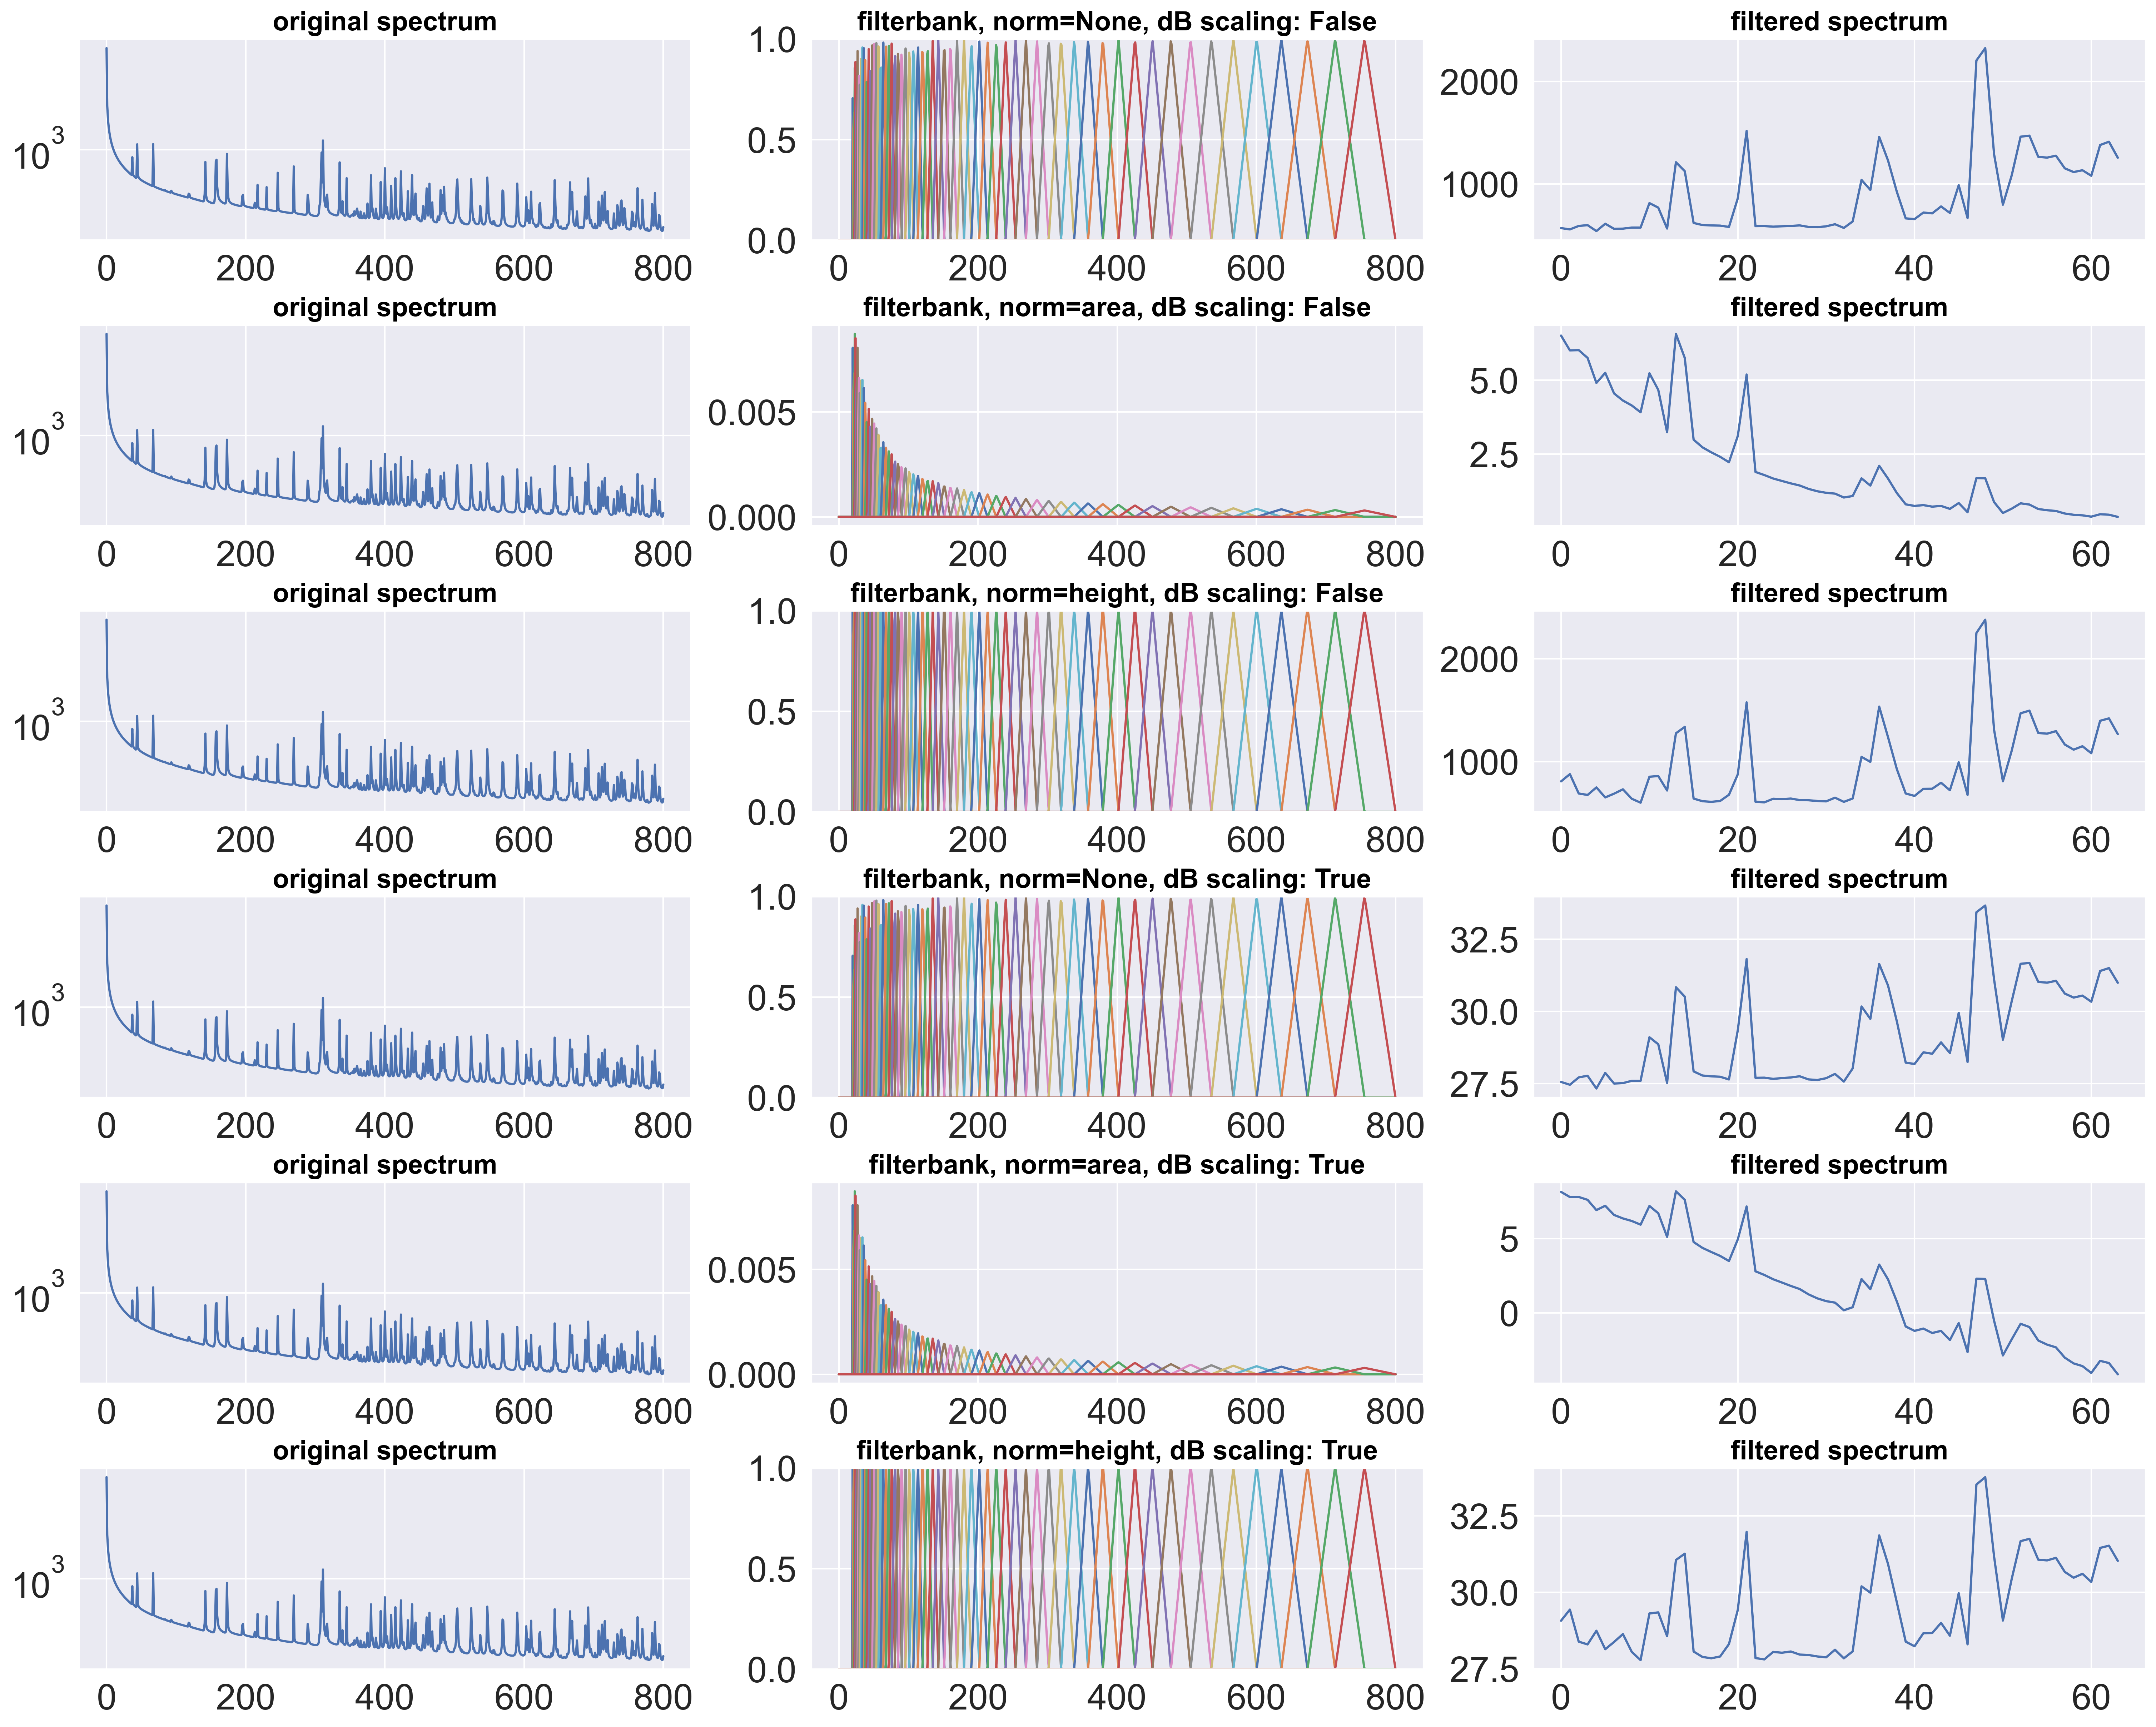

In [6]:
fig, axs = plt.subplots(6, 3, constrained_layout=True, figsize=(20,16))

sr = df['kHz'].iloc[-1]*1000*2 # from measurement, highest f[kHz]*2
n_log_bins = 64
n_fft = 1600
n_fft_bins = 801
f_min = 960*1.5
f_max = sr/2

norm = None
to_dB = False

fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)
log_spec = fb.apply(spec=spec, to_dB=to_dB)

axs[0,0].plot(spec)
axs[0,0].set_title("original spectrum", fontdict=axis_font)
axs[0,0].set_yscale('log')

axs[0,1].plot(fb.weights.T)
axs[0,1].set_title(f"filterbank, norm={norm}, dB scaling: {to_dB}", fontdict=axis_font)
axs[0,1].set(ylim=(0, 1))

axs[0,2].plot(log_spec.T)
axs[0,2].set_title("filtered spectrum", fontdict=axis_font)


norm = 'area'
fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)
log_spec = fb.apply(spec=spec, to_dB=to_dB)

axs[1,0].plot(spec)
axs[1,0].set_title("original spectrum", fontdict=axis_font)
axs[1,0].set_yscale('log')

axs[1,1].plot(fb.weights.T)
axs[1,1].set_title(f"filterbank, norm={norm}, dB scaling: {to_dB}", fontdict=axis_font)
#axs[1,1].set(ylim=(0, 1))

axs[1,2].plot(log_spec.T)
axs[1,2].set_title("filtered spectrum", fontdict=axis_font)

norm = 'height'
fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)
log_spec = fb.apply(spec=spec, to_dB=to_dB)

axs[2,0].plot(spec)
axs[2,0].set_title("original spectrum", fontdict=axis_font)
axs[2,0].set_yscale('log')

axs[2,1].plot(fb.weights.T)
axs[2,1].set_title(f"filterbank, norm={norm}, dB scaling: {to_dB}", fontdict=axis_font)
axs[2,1].set(ylim=(0, 1))


axs[2,2].plot(log_spec.T)
axs[2,2].set_title("filtered spectrum", fontdict=axis_font)




norm = None
to_dB = True
spec = df['real']

fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)
log_spec = fb.apply(spec=spec, to_dB=to_dB)

axs[3,0].plot(spec)
axs[3,0].set_title("original spectrum", fontdict=axis_font)
axs[3,0].set_yscale('log')


axs[3,1].plot(fb.weights.T)
axs[3,1].set_title(f"filterbank, norm={norm}, dB scaling: {to_dB}", fontdict=axis_font)
axs[3,1].set(ylim=(0, 1))


axs[3,2].plot(log_spec.T)
axs[3,2].set_title("filtered spectrum", fontdict=axis_font)


norm = 'area'
fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)
log_spec = fb.apply(spec=spec, to_dB=to_dB)

axs[4,0].plot(spec)
axs[4,0].set_title("original spectrum", fontdict=axis_font)
axs[4,0].set_yscale('log')


axs[4,1].plot(fb.weights.T)
axs[4,1].set_title(f"filterbank, norm={norm}, dB scaling: {to_dB}", fontdict=axis_font)
#axs[4,1].set(ylim=(0, 1))


axs[4,2].plot(log_spec.T)
axs[4,2].set_title("filtered spectrum", fontdict=axis_font)

norm = 'height'
fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)
log_spec = fb.apply(spec=spec, to_dB=to_dB)

axs[5,0].plot(spec)
axs[5,0].set_title("original spectrum", fontdict=axis_font)
axs[5,0].set_yscale('log')

axs[5,1].plot(fb.weights.T)
axs[5,1].set_title(f"filterbank, norm={norm}, dB scaling: {to_dB}", fontdict=axis_font)
axs[5,1].set(ylim=(0, 1))


axs[5,2].plot(log_spec.T)
axs[5,2].set_title("filtered spectrum", fontdict=axis_font);